# SLT-CE-4: Constant Shift Embedding

## Task

Many real-world phenomena are described by pairwise proximity data, modeling interactions between the entities of the system. This in contrast to the more common situation where each data sample is given as a feature vector. Even though the clustering of the proximity data may be performed directly on the data matrix, there are some advantatages of  embedding the data into a vector space. For example, it enables the use of some standard preprocessing techniques such as denoising or dimensionality reduction. In this coding exercise, we will explore the tecnhique called _Constant Shift Embedding_ for restating pairwise clustering problems in vector spaces [1] while preserving the cluster structure. We will apply the algorithm described in [1] to cluster the groups of research community members based on the email correspondence matrix. The data and its description is given in [2].

### References 

[1] [Optimal cluster preserving embedding of nonmetric proximity data](https://ieeexplore.ieee.org/document/1251147)

[2] [email-Eu-core](https://snap.stanford.edu/data/email-Eu-core.html)

 <h2 style="background-color:#f0b375;"> Setup </h2>

We start by importing necessary python packages.

In [4]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

# Fix randoom seed for reproducibility
np.random.seed(42)

The number of nodes is hardcoded for simplicity (taken from [2]):

In [5]:
NUM_NODES = 1005

We load the file which contains the list of interactions between the community members (nodes). Our data matrix represents an undirected graph which connects two nodes if there was at least one email sent between the two corresponding community members. Thus our data matrix is essentially an adjacency matrix.

In [6]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

Note that DATA specifies an adjacency matrix of the email graph. It's not claimed to be a proper dissimilarity matrix required by CSE algorithm. So, you are allowed to perform any manipulations to construct a suitable (dis-)similarity matrix for the further analysis.

Next we define a class which contains main functionalities - TO BE IMPLEMENTED.

In [7]:
class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.N = None
        self.PMAT = None
        self.D = None
        self.D_c = None
        self.S_c = None
        self.D_tilde = None
        self.S_tilde = None
        self.D_tilde_c = None
        self.S_tilde_c = None
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.PMAT = PMAT
        
        ## IMPLEMENT THIS METHOD

        # Dissimilarity matrix
        graph = csr_matrix(self.PMAT)
        dist_matrix = shortest_path(csgraph=graph, directed=False, unweighted=True)
        dist_matrix[dist_matrix == np.inf] = np.max(dist_matrix[dist_matrix != np.inf]) * 2

        # Symmetrize
        self.D = 0.5*(dist_matrix + dist_matrix.T)

        # Centralize
        self.n = self.D.shape[0]

        O_n = np.ones(self.D.shape)
        I_n = np.identity(self.n)
        Q = I_n - 1/self.n * O_n
        self.D_c = np.dot(Q, self.D).dot(Q)
        self.S_c = - 0.5 * self.D_c

        # Diagonal shift
        lambda_min = np.linalg.eigvalsh(self.S_c)[0]
        self.S_tilde = self.S_c - lambda_min * np.identity(self.n)

        # Off-diagonal shift
        self.D_tilde = self.D - 2 * lambda_min * (O_n - I_n)

        # Centering
        self.D_tilde_c = np.dot(Q, self.D_tilde).dot(Q)
        self.S_tilde_c = - 0.5 * self.D_tilde_c
        
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """

        eigp, vp = np.linalg.eigh(self.S_tilde_c)
        idx = eigp.argsort()[::-1] 
        eigp = eigp[idx]
        vp = vp[:,idx]
        Xp = np.dot(vp[:,:p], np.sqrt(np.diag(eigp[:p])))

        S_tilde_denoised = np.dot(Xp, Xp.T)
        D_tilde_denoised = np.zeros(S_tilde_denoised.shape)

        diagonal = np.diag(S_tilde_denoised)
        D_tilde_denoised  = diagonal[:, np.newaxis] + diagonal - 2 * S_tilde_denoised 
        
        return Xp, D_tilde_denoised









<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">Describe briefly and consicely the model given in [1]. Explain the main steps of _Constant Shift Embedding_ algorithm. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Constant Shift Embedding**:

    - **1. Symmetrization:** 
        $D_{s} = \frac{1}{2}(D + D^T)$ where D is a Dissimilarity matrix
    
    - **2. Centralization:**
        $S_{c} = \frac{1}{2}D_{c}$  with  $D_{c}= QD_{s}Q$  with  $Q = I - \frac{1}{n}1_n$
    
    - **3. Shift:**
        $\tilde{D}$ = $D_{s} - 2 \lambda_{min}(S_c)(\frac{1}{n}1_n - I)$

- **Reconstructing the Embedded Vectors**

    - **1. Centering:** 
        $\tilde{S}_{c} = \frac{1}{2}\tilde{D_c}$ with $\tilde{D_c} = Q\tilde{D}Q$
        
    - **2. Loss-free reconstruction:**
        $X_p = V_p(\Lambda_p)^{1/2}$
    
    - **3. Approximation & denoising:**
        $X_t = V_t(\Lambda_t)^{1/2}$ where $t<p$


<p style="background-color:#adebad;">
    Implement Constant Shift Embedding. We start off by making an instance of the corresponding class.
</p>    

In [8]:
CSE = ConstantShiftEmbedding()

<p style="background-color:#adebad;">
    Fit the data matrix. _fit(...)_ method computes necessary variables which can be later on used to produce embeddings [1].
</p>    

In [9]:
CSE.fit(DATA)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>


<p style="background-color:#adebad;">
    Next, try to find approximately optimal $p = p^∗$, a cut-off value which removes noise from the data. To do that, produce an eigen-spectrum plot as shown in [1] figure 4a and briefly explain your choice of $p^∗$.
</p>

In [10]:
## Compute eigen-spectrum
eig = np.linalg.eigvalsh(CSE.S_c)[::-1]
eig[eig < 0] = 0

In [11]:
## Determine a good cut-off value (and write some lines to explain your choice)
p_opt = 35 ## change accordingly
print("Chosen cut-off value is: ", p_opt)

Chosen cut-off value is:  35


We chose a cut-off value 35. We based our choice on the elbow method (see graphs below). The rate of change for the subsequent eigenvalues is considerably low (Eigenvalue gradient plot below).

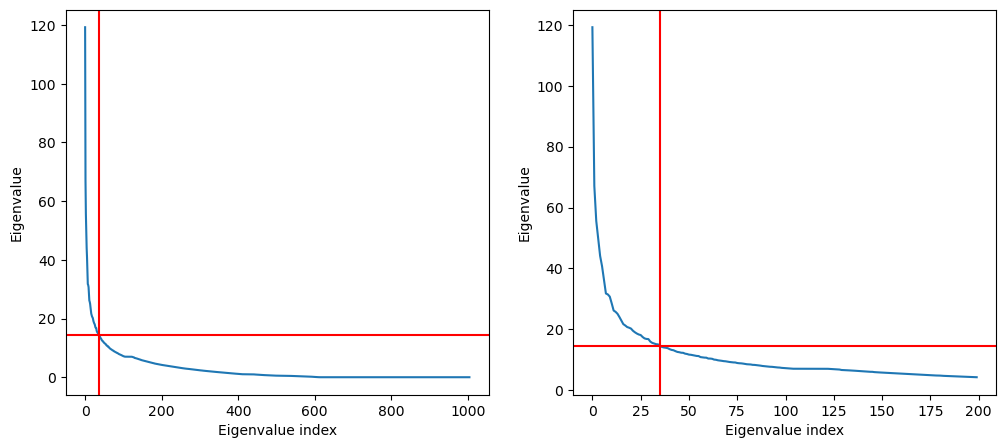

In [12]:
## Plot spectrum and indicate the cut-off value on the spectrum
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(eig)
plt.axhline(eig[p_opt], color='red')
plt.axvline(p_opt, color='red')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.subplot(122)
plt.plot(eig[0:200])
plt.axhline(eig[p_opt], color='red')
plt.axvline(p_opt, color='red')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.show()

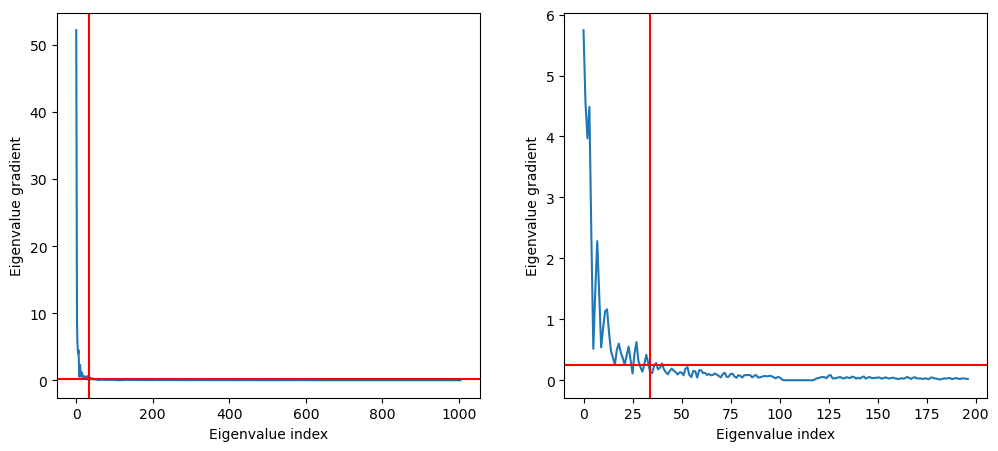

In [136]:
gradient = -np.gradient(eig)

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(gradient)
plt.axhline(gradient[p_opt-1], color='red')
plt.axvline(p_opt-1, color='red')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue gradient')
plt.subplot(122)
plt.plot(gradient[3:200])
plt.axhline(gradient[p_opt-1], color='red')
plt.axvline(p_opt-1, color='red')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue gradient')
plt.show()

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Plot the distance matrices both for the denoised ($p = p^*$ -- from the previous step) and the original versions as shown in figure 5 in [1]. Note that the distance matrix is a matrix with pairwise distances between every two points from the dataset ($d_{ij} = dist(x_i, x_j)$).<br>
    Perform K-MEANS algorithm for varying number of clusters K on the embedded vectors derrived from CSE. You may use the sklearn implementation of K-MEANS. To make the aforementioned plots meaningful, sort the nodes according to the cluster belongings for every number of clusters K (see the figure 5). For now, there is no need to include the actual ground truth labels given in [2].
</p>

In [13]:
def match_cluster_labels(matrix1, matrix2, num_clusters=10):
    
    # Flatten the matrices
    matrix1_flat = np.reshape(matrix1, (-1,))
    matrix2_flat = np.reshape(matrix2, (-1,))
    
    # Calculate cost matrix
    cost_matrix = np.zeros((num_clusters, num_clusters), dtype=int)

    for cluster in range(num_clusters):
        matrix2_indices = np.where(matrix2_flat == cluster)[0]
        matrix1_indices_list = np.array([np.where(matrix1_flat == i)[0] for i in range(num_clusters)])
        intersections = np.array([np.intersect1d(matrix2_indices, matrix1_indices).size for matrix1_indices in matrix1_indices_list])
        cost_matrix[cluster, :] = intersections

    inverted_cost_matrix = np.max(cost_matrix) - cost_matrix

    # Perform Hungarian algorithm 
    row_ind, col_ind = linear_sum_assignment(inverted_cost_matrix)
    cluster_mapping = dict(zip(row_ind, col_ind))


    # Remap labels in second matrix
    remapped_matrix2 = matrix2_flat.copy()
    for cluster in range(num_clusters):
        remapped_matrix2[matrix2_flat == cluster] = cluster_mapping[cluster]

    # Reshape remapped matrix to original
    remapped_matrix2 = np.reshape(remapped_matrix2, matrix2.shape)

    return remapped_matrix2, cluster_mapping

/var/folders/vn/mllgs9t95s722nyhhjxsd_vr0000gp/T/ipykernel_23068/3718765661.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matrix1_indices_list = np.array([np.where(matrix1_flat == i)[0] for i in range(num_clusters)])
/var/folders/vn/mllgs9t95s722nyhhjxsd_vr0000gp/T/ipykernel_23068/3718765661.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  matrix1_indices_list = np.array([np.where(matrix1_flat == i)[0] for i in range(num_clusters)])
/var/folders/vn/mllgs9t95s722nyhhjxsd_vr0000gp/T/ipykernel_23068/3718765661.py:12: VisibleDeprecationWarning

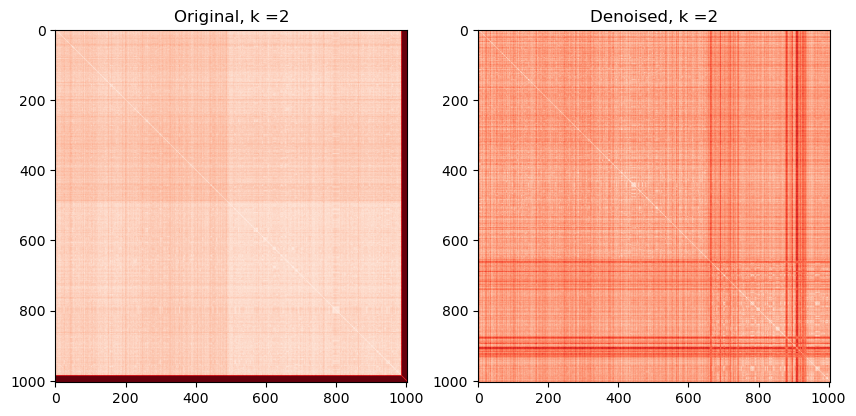

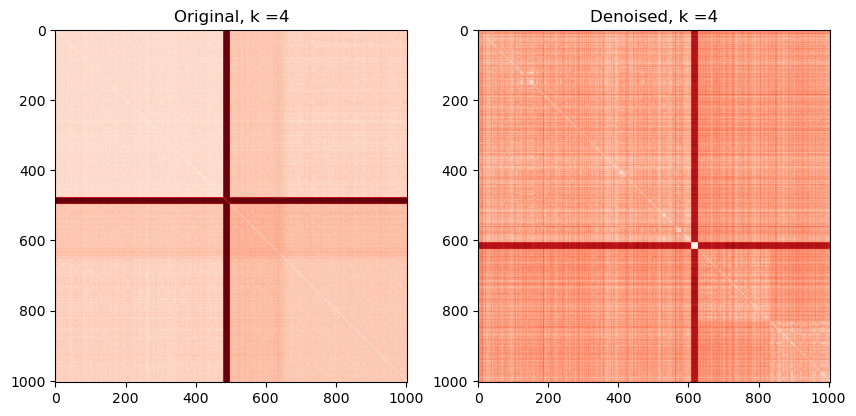

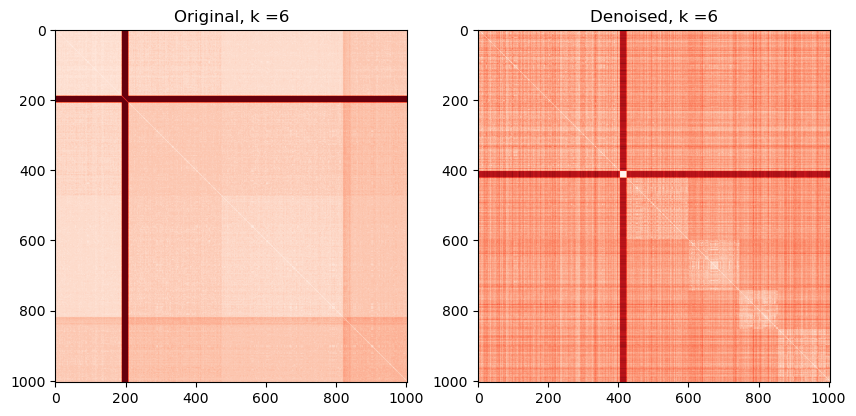

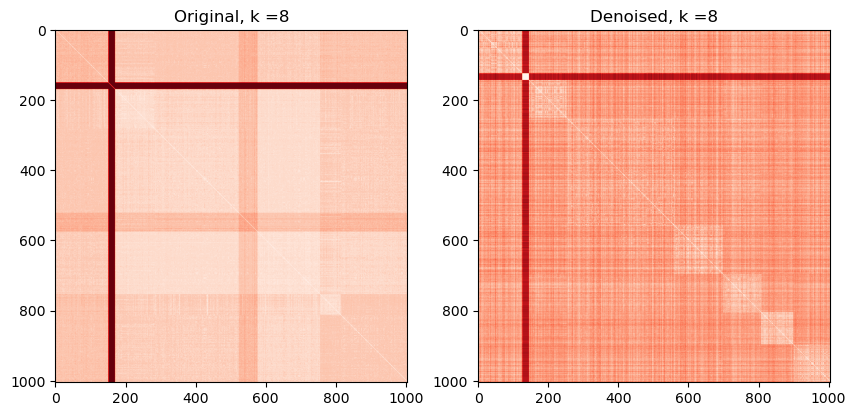

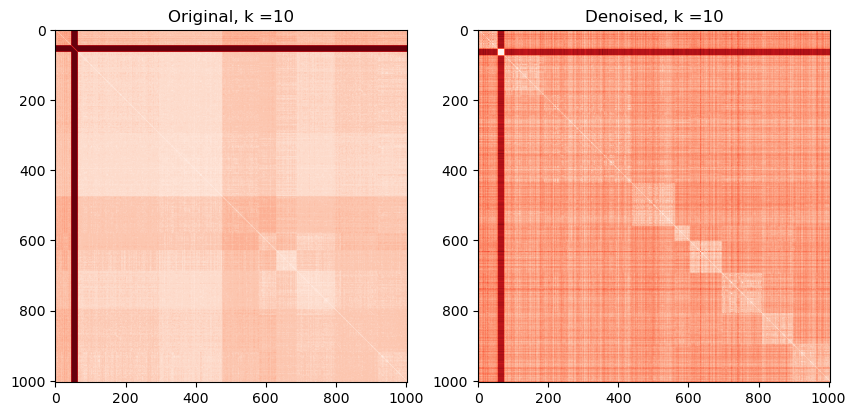

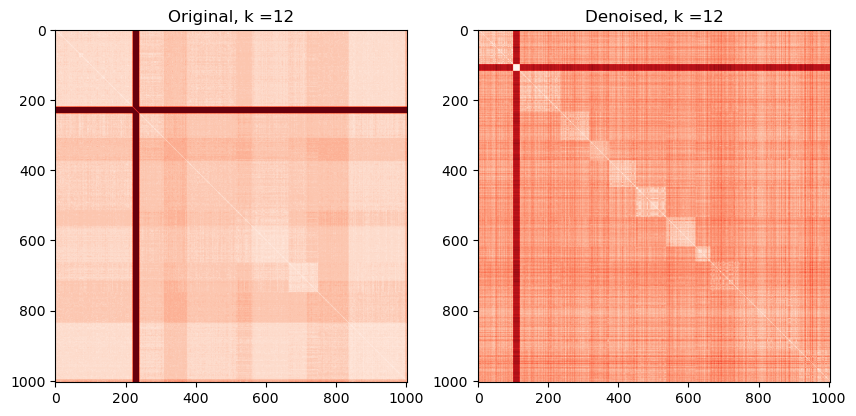

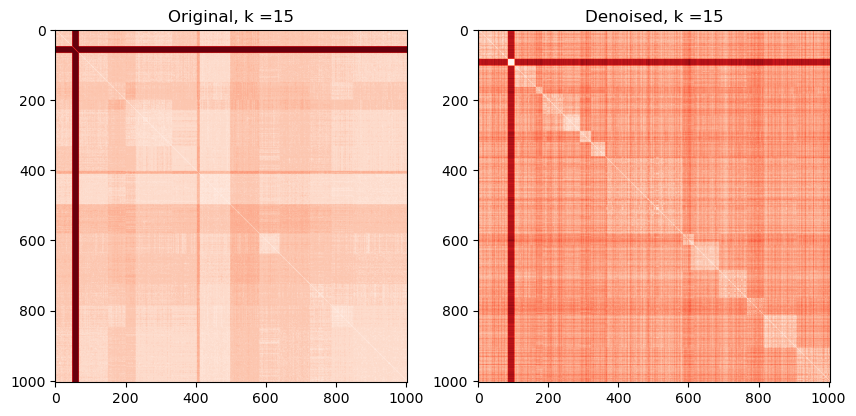

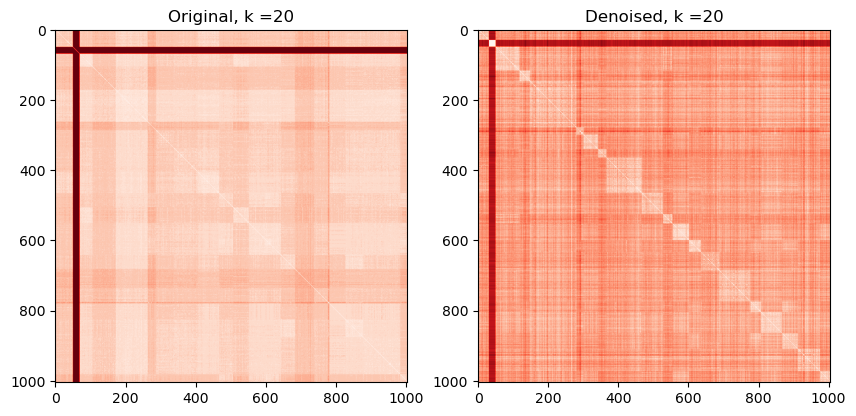

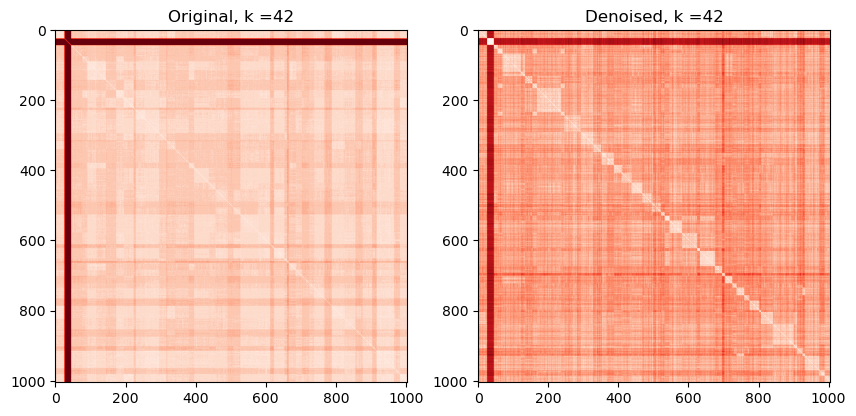

In [14]:
Xp, d_tilde = CSE.get_embedded_vectors(p_opt)


# clusters
clust_size = [2, 4, 6, 8, 10, 12, 15, 20, 42]

for k in clust_size:

    # Kmeans
    labels = KMeans(n_clusters=k, random_state= 42, n_init=5).fit_predict(Xp)
    labels_orig = KMeans(n_clusters=k, random_state= 42, n_init=5).fit_predict(CSE.D)
    labels = match_cluster_labels(labels_orig, labels, num_clusters=k)[0]

    # Permute for cluster labels
    idx = np.argsort(labels)
    idx_orig = np.argsort(labels_orig)

    # Plot Matrices
    plt.figure(figsize=(10,8))
    plt.subplot(121)
    plt.imshow(CSE.D[idx_orig][:,idx_orig], cmap = 'Reds')
    plt.title("Original, k =" + str(k))
    plt.subplot(122)
    plt.imshow(d_tilde[idx][:,idx], cmap = 'Reds')
    plt.title("Denoised, k =" + str(k))
    plt.show



<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    Producing 2D and 3D embeddings allows us to nicely visualize generated clusters. Now calculate the embeddings for p = 2 (2D case) and p = 3 (3D case) and plot clusterings for a few values of K.  Alternatively, you could use $p = p^*$ for more gentle denoising, cluster the denoised embeddings and only then apply a dimensionality reduction technique to get a plot in 2,3-dimensional space. You could use PCA, LLE, t-SNE etc. figure out what works for you. As an example see figure 6 (b) from [1] where CSE is combined with PCA.
</p>

In [ ]:
## Get embeddings, run K-MEANS and generate plots

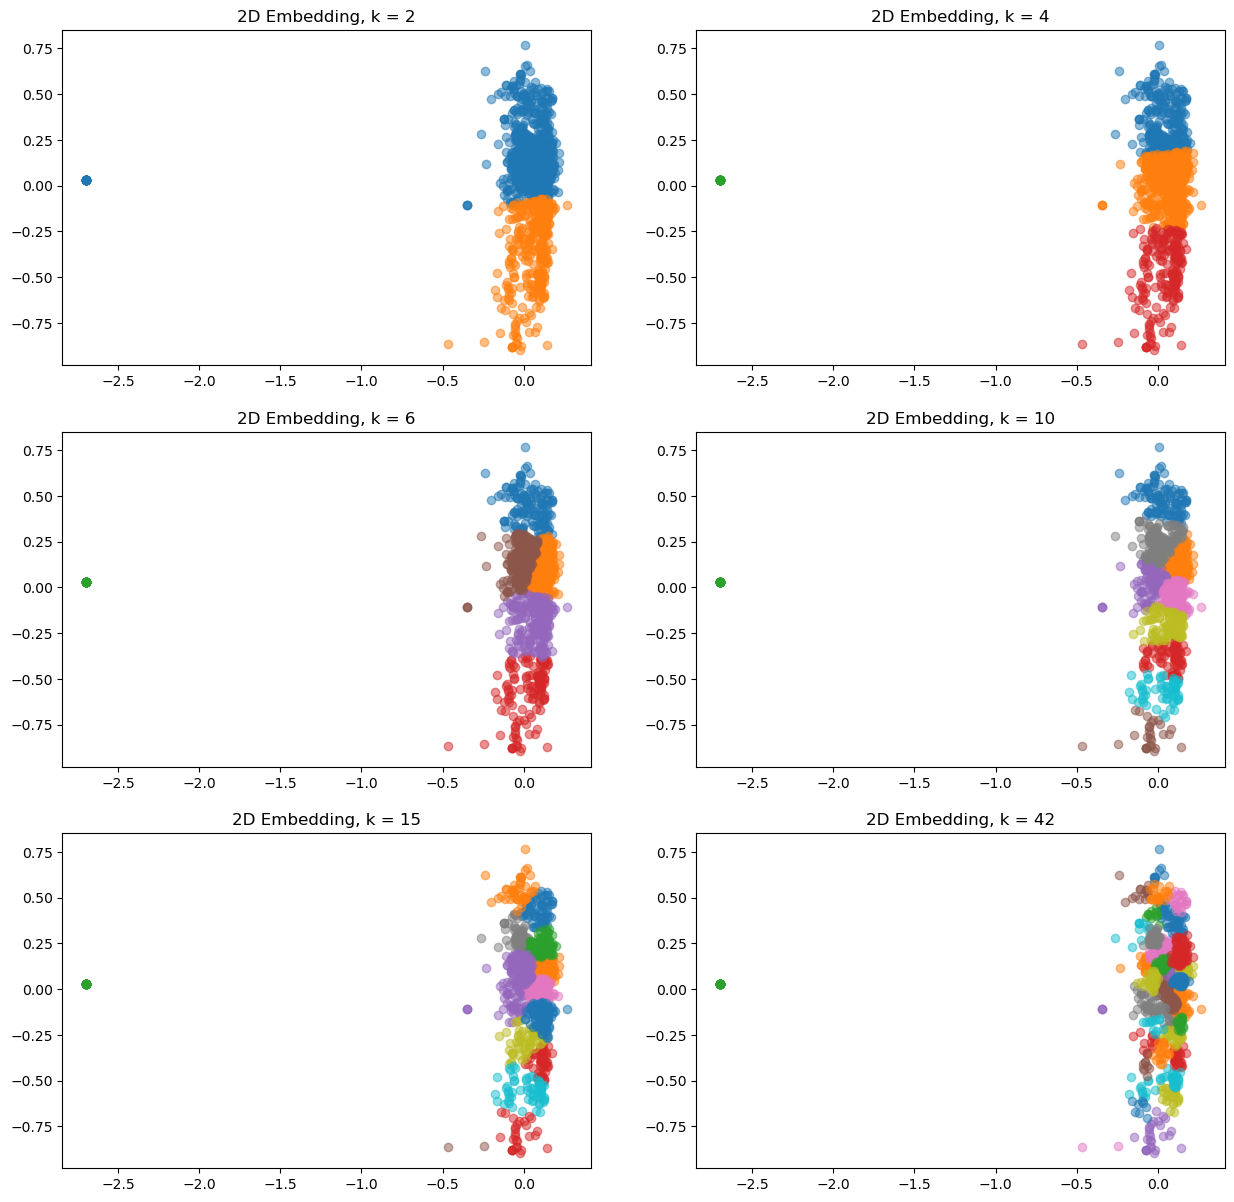

In [138]:
## p = 2

Xp = CSE.get_embedded_vectors(p = 2)[0]

clust_size = [2, 4, 6, 10, 15, 42]

plt.figure(figsize =(15,20))
i = 0
for k in clust_size:
    KM = KMeans(n_clusters=k, random_state= 42, n_init='auto')
    labels = KM.fit_predict(Xp)
    plt.subplot(421 + i)
    for label in np.unique(labels):
        plt.scatter(Xp[np.where(labels == label),0], Xp[np.where(labels == label),1], alpha= 0.5)

    plt.title('2D Embedding, k = ' + str(k))
    i += 1
plt.show()



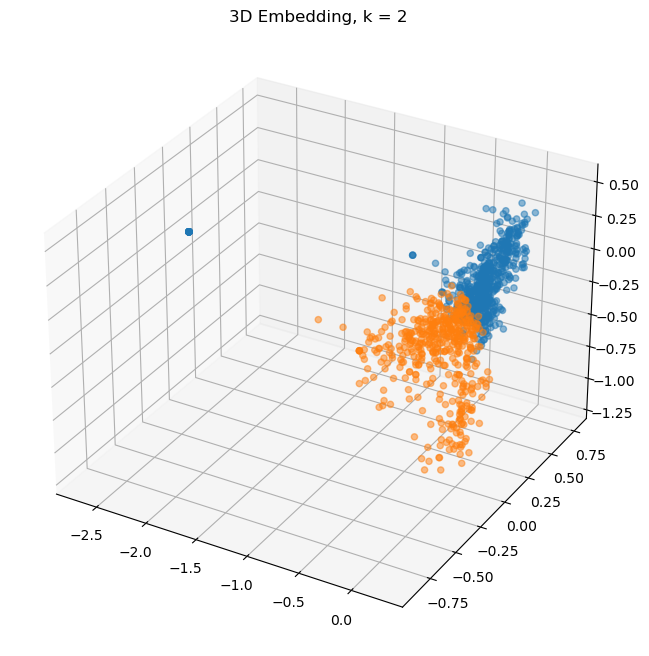

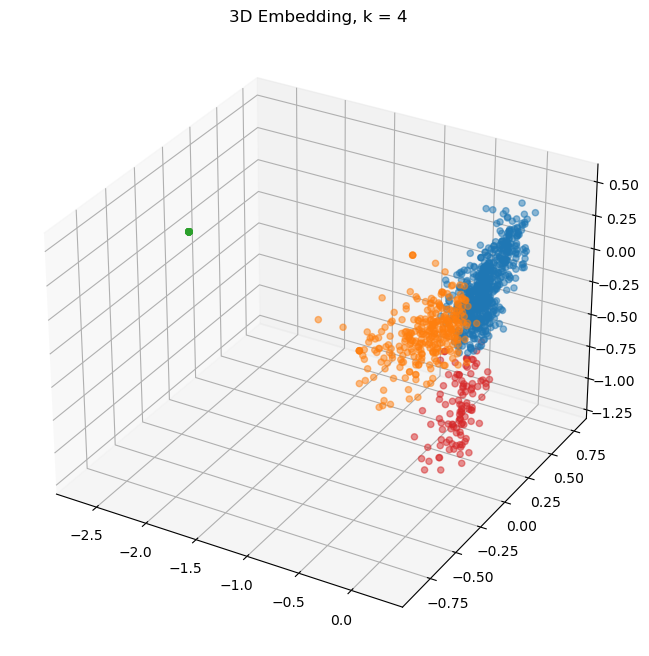

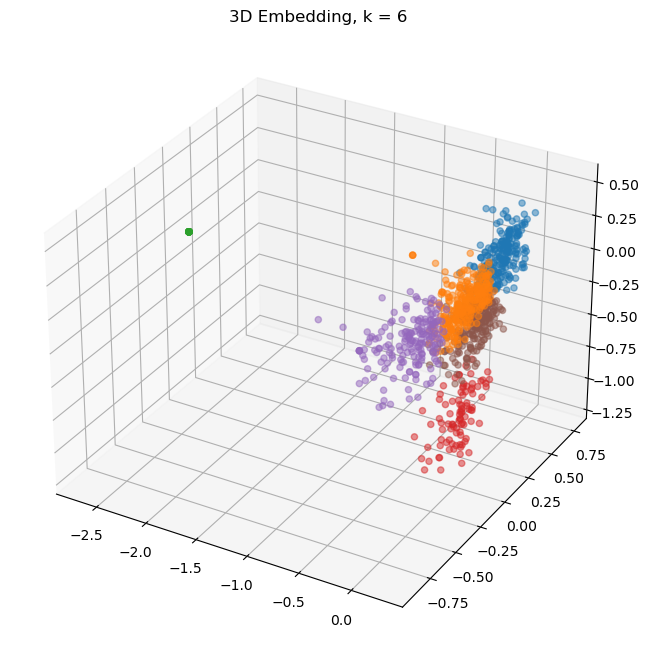

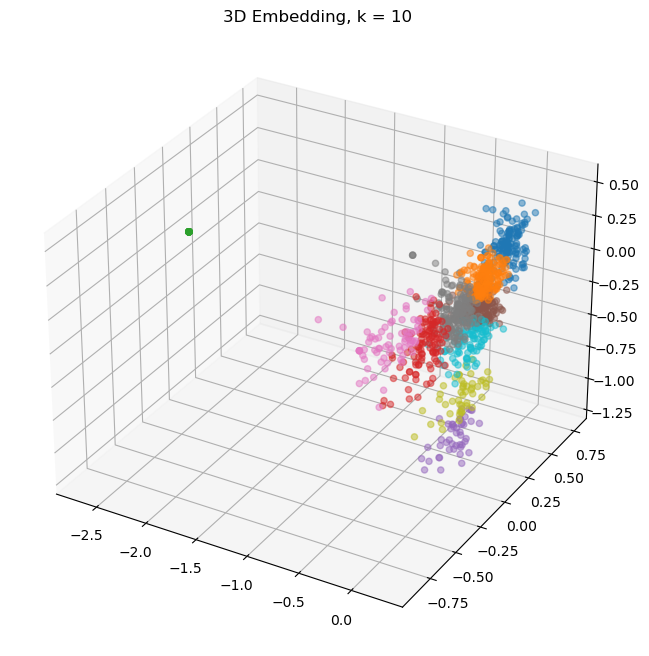

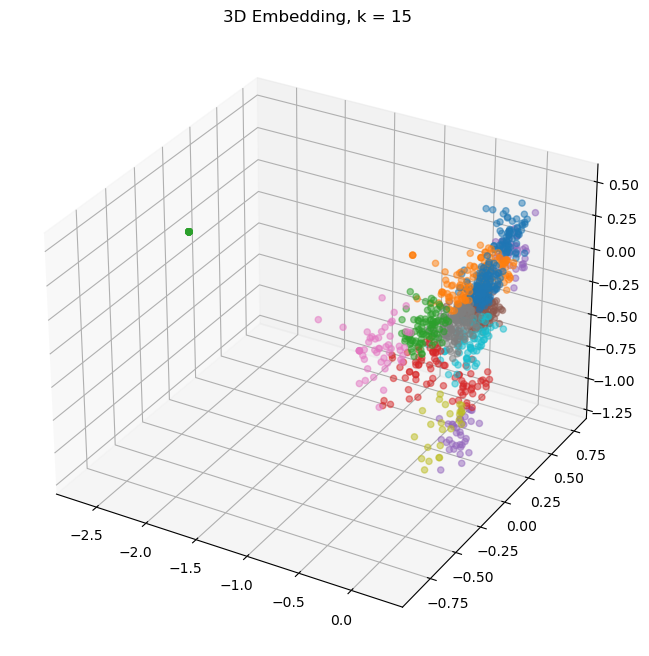

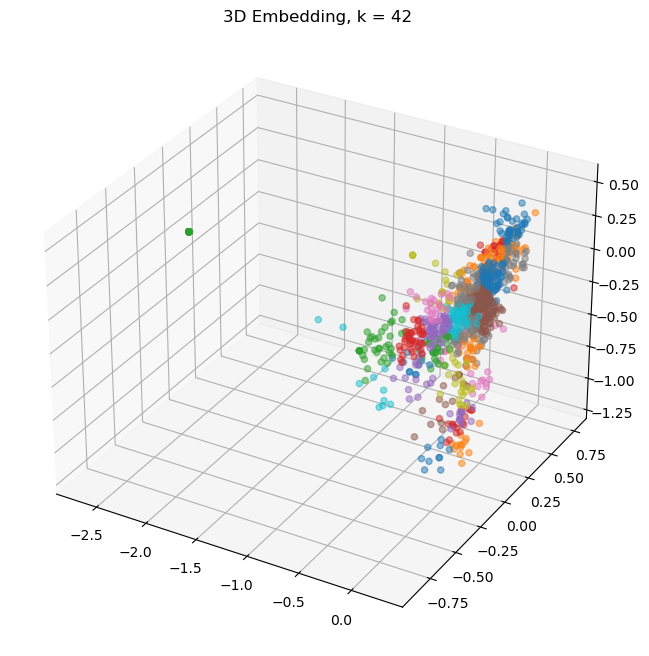

In [139]:
## p = 3

Xp = CSE.get_embedded_vectors(p = 3)[0]
clust_size = [2, 4, 6, 10, 15, 42]

for k in clust_size:
    KM = KMeans(n_clusters=k, random_state= 42, n_init='auto')
    labels = KM.fit_predict(Xp)
    
    plt.figure(figsize =(8,8))
    ax = plt.axes(projection ="3d")
    for label in np.unique(labels):
        ax.scatter(Xp[np.where(labels == label),0], Xp[np.where(labels == label),1], Xp[np.where(labels == label),2], alpha= 0.5)

    plt.title('3D Embedding, k = ' + str(k))
    plt.show()


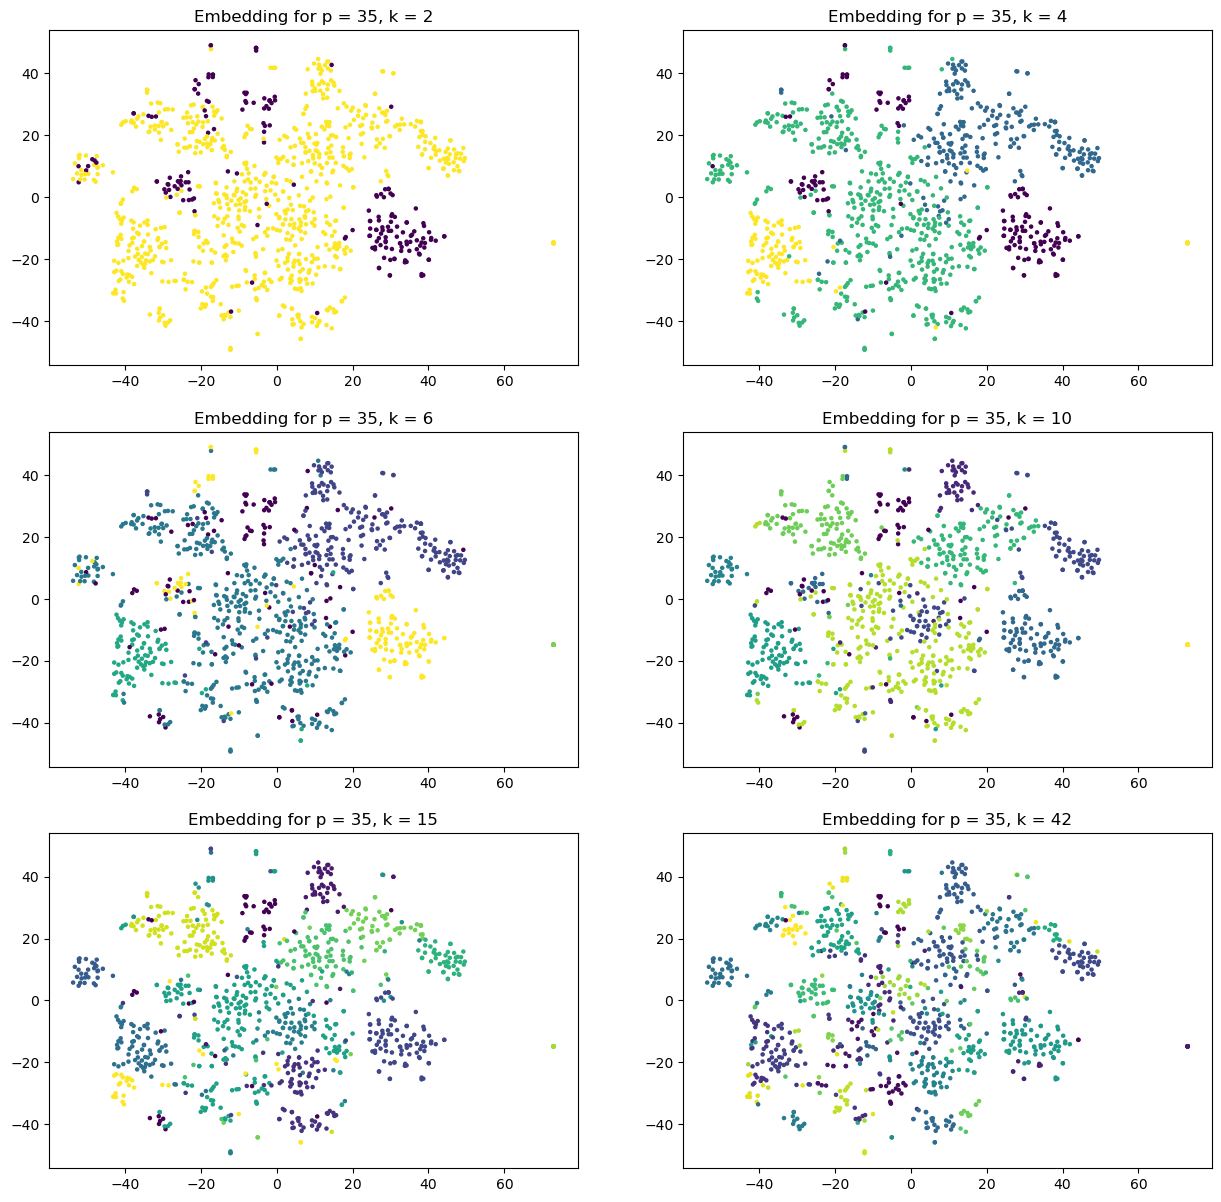

In [140]:
## choose p > 3, for example, p = p_opt, to compute CSE embeddings 
## First, cluster the computed p-dimentional embeddings and then project them onto 2-dimensional space 
## for visualization using PCA, LL, t-SNE or something else


Xp = CSE.get_embedded_vectors(p = p_opt)[0]

clust_size = [2, 4, 6, 10, 15, 42]

i = 0
plt.figure(figsize =(15,20))
for k in clust_size:
    KM = KMeans(n_clusters=k, random_state= 42, n_init='auto')
    labels = KM.fit_predict(Xp)

    tsne = skl.manifold.TSNE(n_components= 2, random_state=42)
    tsne_xp = tsne.fit_transform(Xp)

    plt.subplot(421 + i)
    plt.scatter(tsne_xp[:,0], tsne_xp[:,1],  c = labels, s = 5)

    plt.title('Embedding for p = ' + str(p_opt) + ', k = ' + str(k))
    i += 1
plt.show()

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Finally, to evaluate the quality of the above derived clusters, let's compare our predictions with the ground truth. We will use the actual member-institution mappings given in [2]. You can reuse code from the previous coding exercises to align the cluster labels with the ground truth.
</p>

In [15]:
# Initialize community members affeliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ",len(np.unique(AFFILIATIONS)))

The true number of clusters (departments) is:  42


<p style="background-color:#adebad;">
Visually or quantitatively, in a clever and convincing way, show that the K-MEANS generated clusters overlap with the ground truth clusters (member affiliations). How can we measure the overlapping of the predicted and true clusters?
</p>

In [ ]:
## Here you can provide plots and calculations

Xp, d_tilde = CSE.get_embedded_vectors(p = p_opt)
    
labels = KMeans(n_clusters=42, random_state= 42).fit_predict(Xp)

matched_labels = match_cluster_labels(AFFILIATIONS, labels, num_clusters=42)[0]

tsne = skl.manifold.TSNE(n_components= 2, random_state=42)
tsne_xp = tsne.fit_transform(Xp)

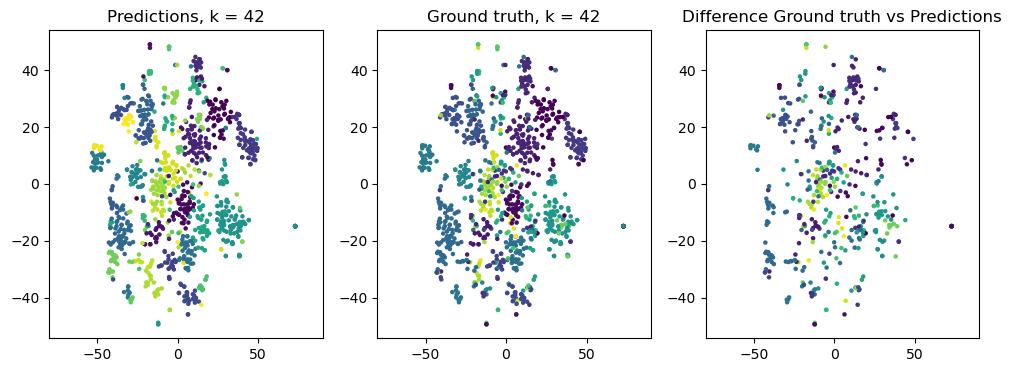

In [17]:
plt.figure(figsize =(12, 4))
plt.subplot(131)
plt.scatter(tsne_xp[:,0], tsne_xp[:,1],  c = matched_labels, s = 5)
plt.title('Predictions, k = 42')
plt.xlim(-80, 90)
plt.subplot(132)
plt.scatter(tsne_xp[:,0], tsne_xp[:,1],  c = AFFILIATIONS, s = 5)
plt.title('Ground truth, k = 42')
plt.xlim(-80, 90)
plt.subplot(133)
plt.scatter(tsne_xp[:,0][matched_labels != AFFILIATIONS], tsne_xp[:,1][matched_labels != AFFILIATIONS],  c = AFFILIATIONS[matched_labels != AFFILIATIONS], s = 5)
plt.title('Difference Ground truth vs Predictions')
plt.xlim(-80, 90)
plt.show()

In [18]:
acc = skl.metrics.accuracy_score(AFFILIATIONS, matched_labels)
print("Accuracy: ", round(acc, 3))

Accuracy:  0.526


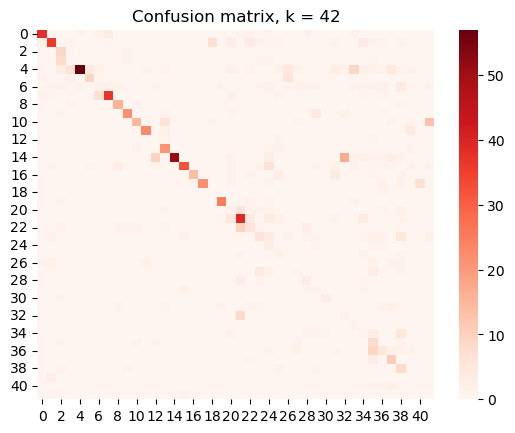

In [146]:
import seaborn as sns
cm = skl.metrics.confusion_matrix(AFFILIATIONS, matched_labels)
sns.heatmap(cm, cmap='Reds')
plt.title('Confusion matrix, k = 42')
plt.show()



In the first plot, we compare the t-SNE embeddings of the predicted labels and the ground truth. By looking at the difference plot, we find some overlapping between our predictions and the ground truth. Thus, K-Means was able to identify some member affiliations. However, a significant number of observations still differ from the ground truth (Accuracy score: 0.526). In the t-SNE plot, we do not see a clear pattern of the deviations.

We further plot the confusion matrix between the ground truth and predicted labels. We find that the predictions for the first clusters (1-20) are quite accurate but differ significantly for clusters 20-42.

The results are however highly dependent on the dissimilarity measure for the graph. A different approach might improve the results significantly.

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.